In [1]:
import sys
sys.path.append('../scripts/')
from main_utils import *

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#############################################################
## SET UP 

M_S = 64
L_S = 32
S = Net(M=M_S, L=L_S) 
print('Single Deep Parameters: ', S.parameters)

# Here are the frequent values in literature and these are going to be the "acceptable values"
L_ = [4, 8, 16, 32, 64]
M_ = [4, 8, 16, 32, 64]
K_ = [4, 8, 16, 32, 64]

Single Deep Parameters:  1235018


## Experiment 1 -- Given S, sweep all values of Le and K, calculate Me
Explanation:  
- 1 - Iterate over all possible values of Le, K to calculate the Me which better fits the budget allowed --> `Candidates`  
- 2 - Sort the candidates by score and keep all of the above a `threshold`  
- 3 - Apply rules like minimum of 4 filters, 4 layers, and 2 networks (we can rethink this)  

In [4]:
# Check all those models have in fact the correct parameters
import pandas as pd
#candidates = pd.DataFrame(columns=['K','Le','Me','Score'])
def score(S,E,K):
    return round( (K * Ek.parameters) / S.parameters, 3)

candidates = list()
for K in K_:
    for Le in L_:
        Me = getM_L(S,K,Le)  
        Ek = Net(Me, Le)
        candidates.append({'K':K, 'Le':Le, 'Me':Me, 'Ek': Ek.parameters, 'Score': score(S,Ek,K), 'Net':Ek})
    
# Sort candidates by Score and keep only those with Score > Threshold
thres = 0.95
candidates = pd.DataFrame(candidates, columns=['K','Le','Me','Score','Net'])      
candidates.sort_values(by='Score', ascending=False, inplace=True)
candidates = candidates[candidates['Score'] > thres]

# Apply rule:  4 <= Le <= 64; 4 <= Me <= 64: 2 <= K <= 64
candidates = candidates[(candidates['Le'] >= 4) & (candidates['Me'] >= 4) & (candidates['K'] >= 2)]

The `candidates` found look like this:

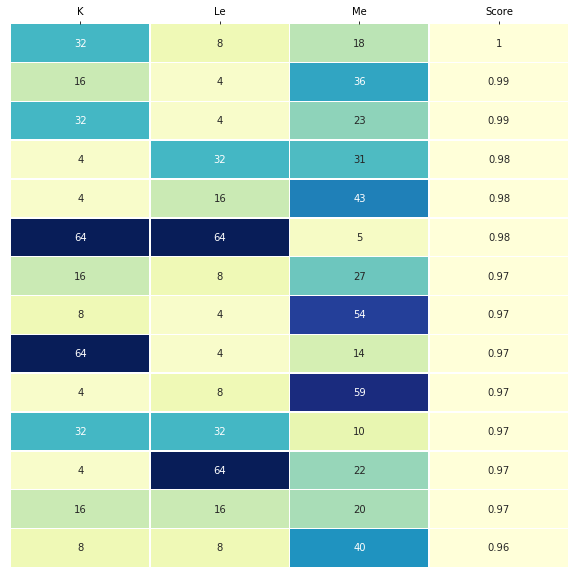

In [5]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(candidates[['K', 'Le', 'Me', 'Score']], 
            yticklabels=False, linewidths=.5, annot=True, cbar=False, cmap="YlGnBu", ax=ax)
ax.xaxis.set_ticks_position('top')

In [6]:
M_range, L_range, K_range = max(M_), max(L_), max(K_)
KLM = np.zeros((L_range, L_range))
KLNumParam = np.zeros((L_range, L_range))
KLNumParamNorm = np.zeros((L_range, L_range))

for K in range(1,K_range):
    for L in range(1,L_range):
        
        # Given K,L, and the deep network, compute M
        KLM[K,L] = getM_L(S,K,L) 
        
        # Compute total number of parameters in the ensemble
        temp_net = Net(M = KLM[K,L], L = L)
        KLNumParam[K,L] = K*temp_net.total()
        
        # Exception when M cannot be computed
        if KLM[K,L] == -1:
            KLNumParam[K,L] = 0

# Normalize KLNumParam
KLNumParamNorm = KLNumParam/np.max(KLNumParam)

[]

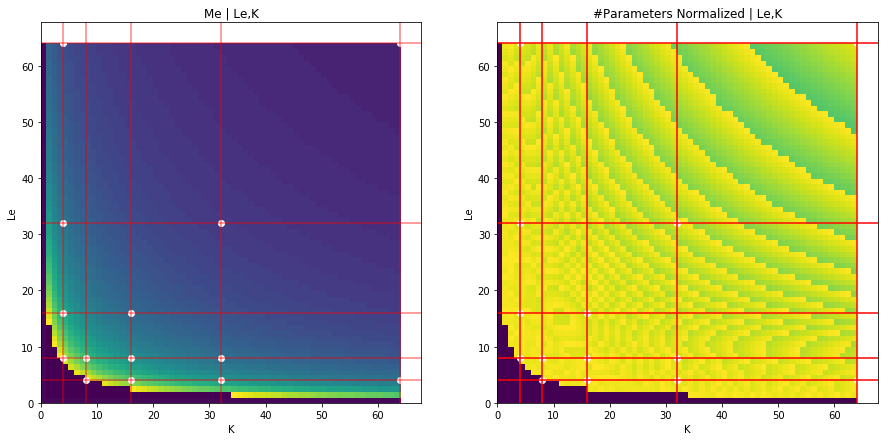

In [7]:
# Find potential candidates #####
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,7))

ax1.set(xlabel='K', ylabel='Le', title='Me | Le,K')
ax1.pcolor(KLM)
[ax1.axvline(k, color='red', alpha=0.5) for k in K_]
[ax1.axhline(l, color='red', alpha=0.5) for l in L_]
ax1.scatter(x=candidates['K'], y=candidates['Le'], color='white', zorder=1)

ax2.set(xlabel='K', ylabel='Le', title='#Parameters Normalized | Le,K')
ax2.pcolor(KLNumParamNorm)
[ax2.axvline(k, color='red') for k in K_]
[ax2.axhline(l, color='red') for l in L_]
ax2.scatter(x=candidates['K'], y=candidates['Le'], color='white', zorder=1)
ax2.plot()


## Experiment 2 -- Given S, sweep all values of Me and K, calculate Le
Explanation:  
- 1 - Iterate over all possible values of Me, K to calculate the Le which better fits the budget allowed --> `Candidates`  
- 2 - Sort the candidates by score and keep all of the above a `threshold`  
- 3 - Apply rules like minimum of 4 filters, 4 layers, and 2 networks (we can rethink this)  

In [8]:
M_S = 64
L_S = 16
S = Net(M=M_S, L=L_S) 
print('Single Deep Parameters: ', S.parameters)

Single Deep Parameters:  644170


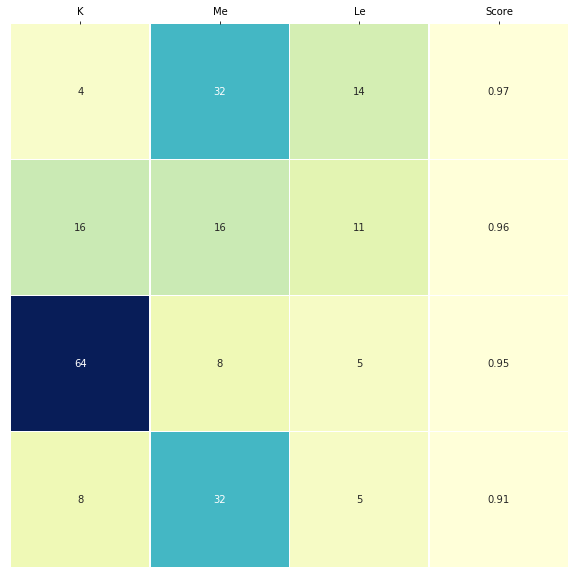

In [9]:
candidates = list()
for K in K_:
    for Me in M_:
        Le = getL_M(S,K,Me)  
        Ek = Net(Me, Le)
        candidates.append({'K':K, 'Le':Le, 'Me':Me, 'Ek': Ek.parameters, 'Score': score(S,Ek,K), 'Net':Ek})
      
candidates = pd.DataFrame(candidates, columns=['K','Le','Me','Score','Net'])      
candidates.sort_values(by='Score', ascending=False, inplace=True)
candidates = candidates[candidates['Score'] > 0.9]

# Apply rule:  4 <= Le <= 64; 4 <= Me <= 64: 2 <= K <= 64
candidates = candidates[(candidates['Le'] >= 4) & (candidates['Me'] >= 4) & (candidates['K'] >= 2)]

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(candidates[['K', 'Me', 'Le', 'Score']], 
            yticklabels=False, linewidths=.5, annot=True, cbar=False, cmap="YlGnBu", ax=ax)
ax.xaxis.set_ticks_position('top')

In [10]:
M_range, L_range, K_range = max(M_), max(L_), max(K_)
KML = np.zeros((L_range, L_range))
KMNumParam = np.zeros((L_range, L_range))
KMNumParamNorm = np.zeros((L_range, L_range))

for K in range(1,K_range):
    for Me in range(1,M_range):
        
        # Given K,L, and the deep network, compute M
        KML[K,Me] = getL_M(S,K,Me) 
        
        # Compute total number of parameters in the ensemble
        temp_net = Net(M = Me, L = KLM[K,Me])
        KMNumParam[K,Me] = K*temp_net.total()
        
        # Exception when M cannot be computed
        if KLM[K,Me] == -1:
            KMNumParam[K,Me] = 0   
            
# Normalize KLNumParam
KMNumParamNorm = KMNumParam/np.max(KMNumParam)

[]

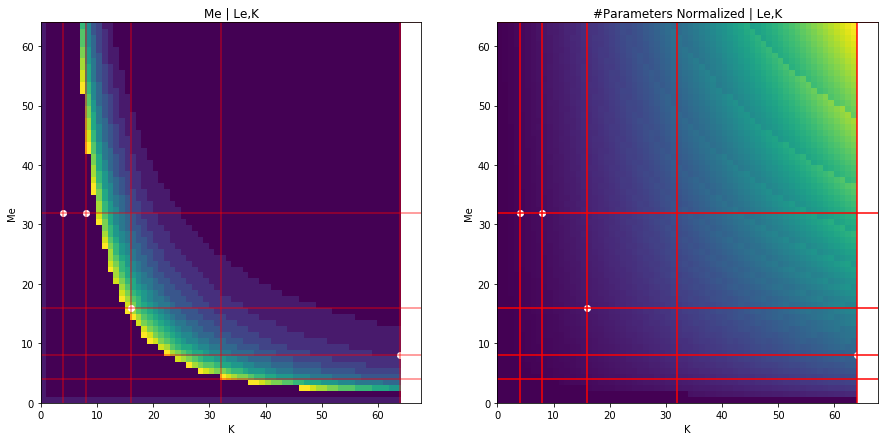

In [11]:
# Find potential candidates #####
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,7))

ax1.set(xlabel='K', ylabel='Me', title='Me | Le,K')
ax1.pcolor(KML)
[ax1.axvline(k, color='red', alpha=0.5) for k in K_]
[ax1.axhline(m, color='red', alpha=0.5) for m in M_]
ax1.scatter(x=candidates['K'], y=candidates['Me'], color='white', zorder=1)

ax2.set(xlabel='K', ylabel='Me', title='#Parameters Normalized | Le,K')
ax2.pcolor(KMNumParamNorm)
[ax2.axvline(k, color='red') for k in K_]
[ax2.axhline(m, color='red') for m in M_]
ax2.scatter(x=candidates['K'], y=candidates['Me'], color='white', zorder=1)
ax2.plot()